# AUDIO CLASSIFICATION BEGINNER TUTORIAL

Welcome!

In this notebook we will build a complete data analytics pipeline to pre-process audio signals and build a classification model able to distinguish between the classes available in the dataset. More specifically, we will load, analyze and prepare the Free Spoken Digit dataset to train and validate a classification model.

About the dataset:
The dataset for this notebook has been inspired by the Free Spoken Digit Dataset.
It is composed of 2,000 recordings of numbers from 0 to 9 with english pronunciation by 4 speakers.
Thus, each digit has a total of 50 recordings per speaker. Each recording is a mono wav file.
The sampling rate is 8 kHz.
The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
The data has been distributed uniformly in two separate collections:
- Development (dev): a collection composed of 1500 recordings with the ground-truth labels. This collection of data has to be used during the development of the classification model. Each file in this portion of the dataset is a recording named with the following format <Id>_<Label>.wav.
- Evaluation (eval): a collection composed of 500 recordings without the labels. This collection of data has to be used to produce the submission file containing the labels predicted for each evaluation recording, exploiting the previously built model. Each file in this portion of the dataset is a recording named with the following format <Id>.wav.


Setup 1 of 2

Let's import first the libraries we will use.

In [2]:
import numpy as np
import csv
import scipy
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, matthews_corrcoef
logistic_cl = linear_model.LogisticRegression()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.warn("deprecated", DeprecationWarning)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17368\3380065843.py:22: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


Setup 2 of 2

First of all it is better to define two distinct functions to load the data from the input folder, one for the development part of the dataset, one for the evaluation part. Since the labels for the development files are encoded in the name of each recording we will have to retrieve and store that information.

In these functions we can use the wavfile package from scipy.io to read the wav audio files.
Loading the data exploiting the wavfile.read() function gives us two main information:
- The sampling rate of the signal (in samples/sec)
- The array with the amplitudes of the signal recorded for each sample

Furthermore we'll define a function for generating the submission file (in case of competition) and a funtion for pre-process the files with three minimal stages in our case:
- Normalization
- Frequency domain transformation
- Sampling

In [3]:


def custom_database_import(in_path):
    # Lấy danh sách các tệp âm thanh trong thư mục đầu vào có đuôi .wav
    index_list = [f for f in os.listdir(in_path) if f.endswith('.wav')]
    
    # Khởi tạo danh sách để chứa các tệp âm thanh và nhãn tương ứng
    in_all_audios = []
    in_y = []
    
    # Duyệt qua danh sách các tệp âm thanh
    for filename in index_list:
#         print(filename)
        # Xây dựng đường dẫn đầy đủ đến tệp âm thanh hiện tại
        full_path = os.path.join(in_path, filename)
        
        # Đọc tệp âm thanh hiện tại và thêm vào danh sách
        rate, data = scipy.io.wavfile.read(full_path, mmap=False)
        in_all_audios.append((rate, data))
        
        # Trích xuất nhãn từ tên tệp và thêm vào danh sách
#         label = filename.split("_")[0] 
        name_parts = filename.split("_")  # tách chuỗi theo dấu gạch dưới
        label = name_parts[0]
#         print('label')
        print(label)
        in_y.append(label)
    
    # Chuyển danh sách nhãn thành một mảng numpy
    out_y = np.array(in_y)
    
    # Trả về danh sách các tệp âm thanh và mảng numpy chứa các nhãn tương ứng
    return in_all_audios, out_y

def custom_eval_database_import(in_path):
    index_list = os.listdir(in_path)
    in_all_audios = []

#     index_list = sorted(index_list, key=lambda x: int(x[:-4]))

    for filename in index_list:
        filename = in_path + f"{filename}"
        in_all_audios.append(scipy.io.wavfile.read(filename, mmap=False))

    return in_all_audios



def custom_csv_print(in_labels, filename):
    list_to_print = []
    for index in range(0, len(in_labels)):
        row_to_print = []
        row_to_print.append(index)
        row_to_print.append(in_labels[index])
        list_to_print.append(row_to_print)

    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Id', 'Predicted'])
        for index in range(0, len(list_to_print)):
            writer.writerow(list_to_print[index])
    return

def custom_preprocess(in_all_audios):
    frequency_preprocessed = []
    all_normalized_audios = []
    all_samples_processed = []

    # Normalization
    for i in range(0, len(in_all_audios)):
        single_normalized_audio = in_all_audios[i][1] / np.max(np.abs(in_all_audios[i][1]))
        all_normalized_audios.append(single_normalized_audio)

    # Frequency Domain
    for i in range(0, len(all_normalized_audios)):
        freq = np.abs(np.fft.fft(all_normalized_audios[i]))
        frequency_preprocessed.append(freq[:freq.shape[0]//2])


    # Sampling
    in_flag = 256
    for i in range(0, len(frequency_preprocessed)):
        single_sample_processed = []
        if in_flag == 256:
            arr_len = len(frequency_preprocessed[i])
            for j in range(in_flag):
                start = j * arr_len // in_flag
                end = (j + 1) * arr_len // in_flag
                single_sample_processed.append(np.mean(frequency_preprocessed[i][start:end]))
        all_samples_processed.append(single_sample_processed)
    return all_samples_processed


We can now start loading the development dataset and pre-process the audio files

In [4]:
all_test_audios, y = custom_database_import("D:\Work\CTU\CT252 - Nien luan co so nganh\Gender-classification\wav_SVM")
# dulieu cua file audio
X = np.array(custom_preprocess(all_test_audios))

Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female
Female

We now split the development dataset in test and training in order to tune our model's hyperparameters and check their scores. In this notebook we'll use two simple models:
- RandomForest Classifier
- MLP Classifier

The ParameterGrid cycle will print the score only if it is better than the last best score, the first is always printed.

In [21]:
import warnings
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('X_train.shape')
print(X_train.shape)
print('X_test.shape')
print(X_test.shape)
print(X)
print(y)
print(y.shape)
print(X.shape)
hyp_parameters = {
'C': [0.1, 1, 10],
}

config_cnt = 0
tot_config = 3
max_f1 = 0


for config in ParameterGrid(hyp_parameters):
    config_cnt += 1
    print(f'Analizing config {config_cnt} of {tot_config} || Config: {config}')
    logistic_clf = linear_model.LogisticRegression(C=config['C'])
    logistic_clf.fit(X_train, y_train)
    y_test_pred = logistic_clf.predict(X_test)
    acc = accuracy_score(y_test_pred, y_test)
    p1, r1, f11, s1 = precision_recall_fscore_support(y_test, y_test_pred)
    macro_f1 = f11.mean()

    if macro_f1 > max_f1:
        max_f1 = macro_f1
        print(f"-----> Score: {macro_f1}")
        print()

X_train.shape
(211, 256)
X_test.shape
(53, 256)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.00521535e-01
  2.02757728e-01 2.46017838e-01]
 [0.00000000e+00 4.69480629e-07 1.01498582e-03 ... 3.54161789e-02
  1.18552247e-01 1.05505631e-01]
 [0.00000000e+00 0.00000000e+00 3.16244353e-04 ... 1.30597514e-01
  1.18335352e-01 1.28994904e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.88339199e-01
  1.78654387e-01 1.46903926e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.88339199e-01
  1.78654387e-01 1.46903926e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.88339199e-01
  1.78654387e-01 1.46903926e-01]]
['Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Fema

Finally, after importing the evaluation dataset, we train our models again with the best hyperparameters configurations found but this time on the entire dataset, then we can proceed to classify the evaluation dataset.

RandomForest:

Analizing config 2 of 12 || Config: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000, 'random_state': 0}
-----> Score: 0.9335100125387632


MLP:

Analizing config 12 of 12 || Config: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 1000, 'random_state': 0}
-----> Score: 0.9660739092226359

(264, 256)
Kết quả logistic_cl tập Test = 
[[30  0]
 [ 4 19]]


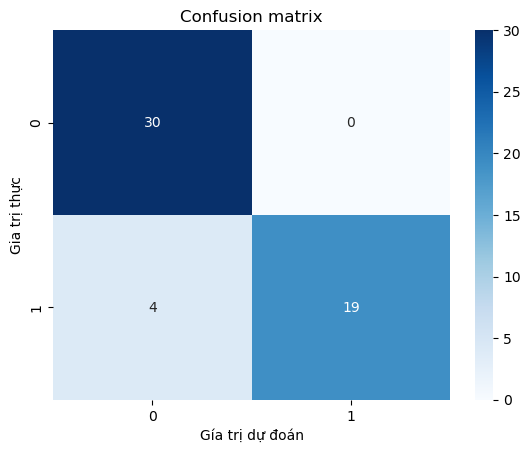

Kết quả logistic_cl tập Test = 
[[20 10]
 [ 0 23]]


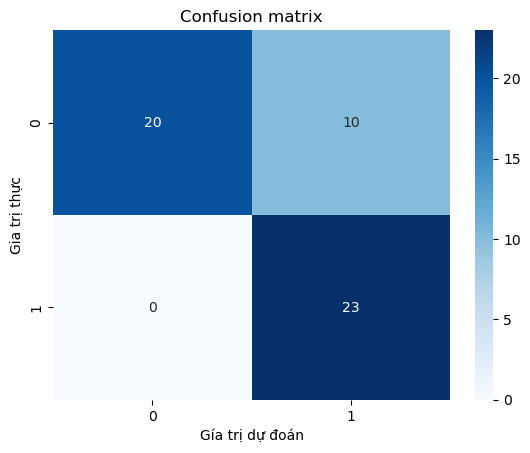

Kết quả logistic_cl tập Test = 
[[27  3]
 [14  9]]


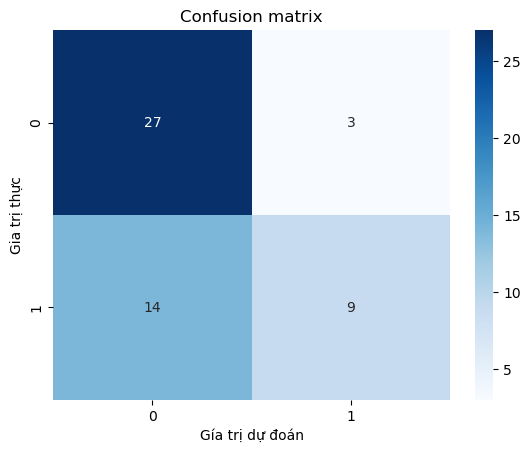

Kết quả logistic_cl tập Test = 
[[22  8]
 [14  9]]


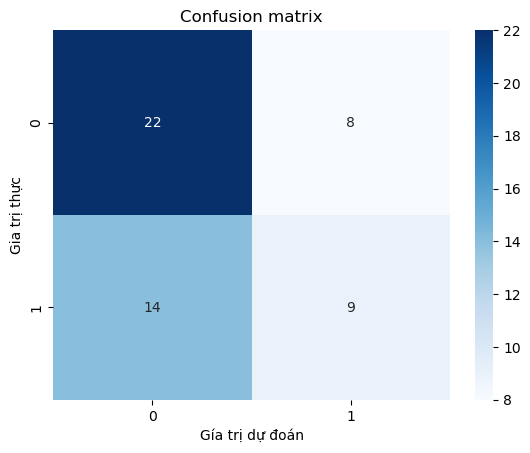

Kết quả logistic_cl tập Test = 
[[20 10]
 [10 12]]


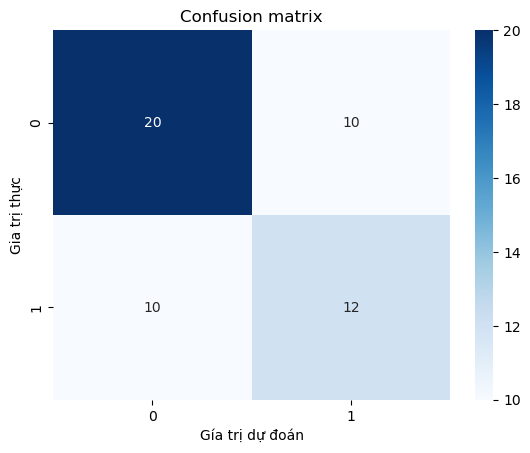

In [26]:
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
logistic_cl = linear_model.LogisticRegression()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
skf =StratifiedKFold(n_splits=5)
skf.get_n_splits(X,y)
print(X.shape)
i=1
file_name = 'fg-logistic.txt'
f_log = open(file_name,"w",encoding="utf-8")

total_train_report = ''
total_test_report = ''

for train_index, test_index, in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train,y_test = y[train_index], y[test_index]
    logistic_cl.fit(X_train,y_train)
    print('Lần lặp' + str(i), file=f_log)

    y_train_pred = logistic_cl.predict(X_train)
    train_report = classification_report(y_train, y_train_pred , digits=5)
    total_train_report += train_report
    print('Kết quả trên tập huấn luyện bằng = ', file=f_log)
    print(train_report, file=f_log)

    print('Kết quả logistic_cl tập Test = ')
    y_test_pred = logistic_cl.predict(X_test)
    test_report = classification_report(y_test, y_test_pred, digits=5 )
    total_test_report += test_report
    print(test_report, file=f_log)  

    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion matrix')
    plt.ylabel('Gia trị thực')
    plt.xlabel('Gía trị dự đoán')
    plt.show()
    i+=1

# Tính trung bình các báo cáo đánh giá trên tập huấn luyện
train_reports = total_train_report.split('\n\n')
train_scores = []
for report in train_reports:
    if 'accuracy' in report or 'f1-score' in report:
        try:
            train_scores.append(float(report.strip().split()[-2]))
        except ValueError:
            pass
avg_train_score = sum(train_scores) / len(train_scores)

f_log.write("Trung bình các báo cáo đánh giá trên tập huấn luyện: {:.4f}\n".format(avg_train_score))



# Tính trung bình các báo cáo đánh giá trên tập kiểm tra
test_reports = total_test_report.split('\n\n')
test_scores = []
for report in test_reports:
    if 'accuracy' in report or 'f1-score' in report:
        try:
            test_scores.append(float(report.strip().split()[-2]))
        except ValueError:
            pass
avg_test_score = sum(test_scores) / len(test_scores)

f_log.write("Trung bình các báo cáo đánh giá trên tập kiểm tra: {:.4f}\n".format(avg_test_score))


f_log.close()


In [23]:

from sklearn.metrics import classification_report
from sklearn.svm import SVC
import numpy as np

all_eval_audios, y_eval = custom_database_import("D:\Work\CTU\CT252 - Nien luan co so nganh\Gender-classification\eval")
X_eval = np.array(custom_preprocess(all_eval_audios))

logistic_clf = linear_model.LogisticRegression(C=1)
logistic_clf.fit(X, y)
logistic_y_final_pred = logistic_clf.predict(X_eval)

print(classification_report(y_eval, logistic_y_final_pred))
result = str(logistic_y_final_pred)
print("Kết quả của " + str(y_eval) + " là " + result)

custom_csv_print(logistic_y_final_pred, 'logistic_out')

Female
Female
Male
Male
Male
              precision    recall  f1-score   support

      Female       0.40      1.00      0.57         2
        Male       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5

Kết quả của ['Female' 'Female' 'Male' 'Male' 'Male'] là ['Female' 'Female' 'Female' 'Female' 'Female']


This conclude the basic audio classification exercise. Better score can be achieved through a better preprocessing, choice of classification algorithm and hyperparameter tuning.

Hope you find this notebook helpful and if you do please upvote :)

Alberto